In [91]:
from utils import unpickle
import torch
# import torchvision
# import torchvision.transforms as T
# import random
import numpy as np
# from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
# from cs231n.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD
from PIL import Image
from pipeline import BuildDataset

In [107]:
img_size = 224

In [4]:
BuildDataset.transformer(224)

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
)

In [5]:
best = '4566c335e71f215a1110a36a7cfec1882c86f86dbb7e3e5787dfdc26'
model, _, _ = unpickle(f'results/{best}_experiment_results.pkl')

In [142]:
def compute_saliency_maps(A, I, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - A: Input audio; Tensor of shape (N, 1, 96, 64)
    - I: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Make input tensor require gradient
    # A.requires_grad_()
    I.requires_grad_()
    
    saliency = None

    scores = model(A, I).gather(1, y.view(-1, 1)).squeeze()
    scores.backward(torch.ones(scores.size()))
    saliency, _ = torch.max(I.grad.abs(), dim=1)

    return saliency

def show_saliency_maps(A, I, y):
    # Convert X and y from numpy arrays to Torch Tensors
    I_tensor = torch.cat([
        BuildDataset.transformer(img_size)(Image.fromarray(i)).unsqueeze(0)
        for i in I], dim=0)
    A_tensor = torch.cat([a.unsqueeze(0) for a in A])
    y_tensor = torch.LongTensor(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(A_tensor, I_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = len(I)
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(I[i])
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

### Get datas

In [144]:
class_names = {0: 'Not', 1: 'Kissing'}

In [84]:
vids = {
    '/Users/aziai/Downloads/movies_casino_royale_2006_kissing_2.mp4': [0, 35, 51],
    '/Users/aziai/Downloads/movies_casino_royale_2006_not_1.mp4': [0, 4, 9],
    '/Users/aziai/Downloads/movies_goldeneye_1995_kissing_1.mp4': [1, 4, 2],
    '/Users/aziai/Downloads/movies_goldeneye_1995_not_2.mp4': [3, 10, 12]
}

In [ ]:
features = {
    vid: BuildDataset.one_video_extract_audio_and_stills(vid)
    for vid in vids
}

In [126]:
features.keys()

dict_keys(['/Users/aziai/Downloads/movies_casino_royale_2006_kissing_2.mp4', '/Users/aziai/Downloads/movies_casino_royale_2006_not_1.mp4', '/Users/aziai/Downloads/movies_goldeneye_1995_kissing_1.mp4', '/Users/aziai/Downloads/movies_goldeneye_1995_not_2.mp4'])

In [128]:
features['/Users/aziai/Downloads/movies_casino_royale_2006_kissing_2.mp4'][0][0].shape

torch.Size([1, 96, 64])

In [97]:
def shenanigans(x: torch.Tensor) -> np.array:
    rev = BuildDataset.transform_reverse(x)
    return np.array(rev)

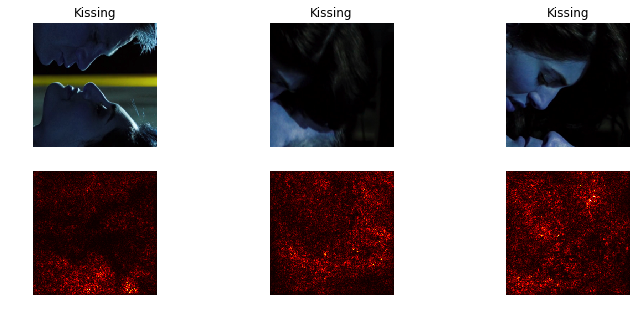

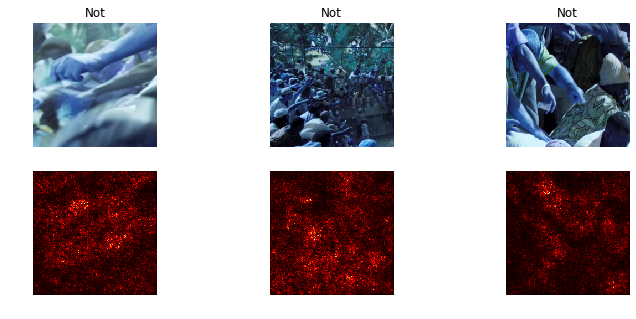

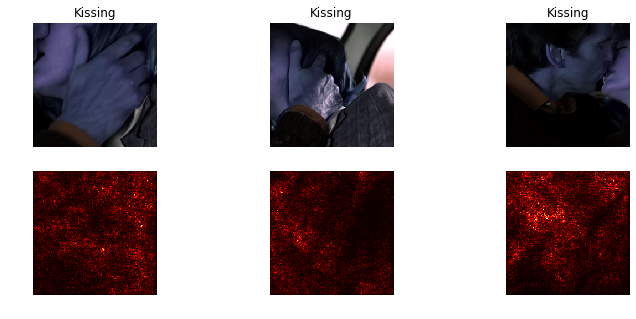

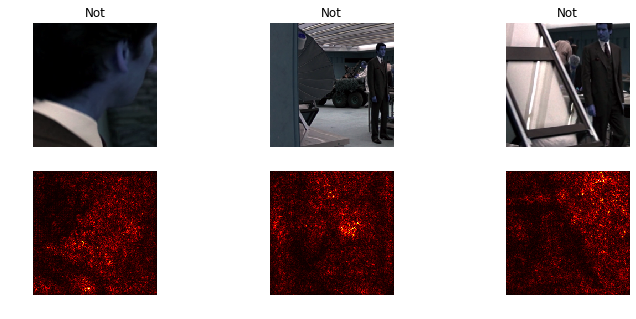

In [146]:
for vid, indices in vids.items():
    A = [features[vid][0][idx] for idx in indices]
    I = [shenanigans(features[vid][1][idx]) for idx in indices]
    y = [1 if 'kissing' in vid else 0] * len(x)
    show_saliency_maps(A, I, y)
    print('=' * 10)